# Attempting some basic aperture photometry (yeet)

Based on method used in previous source detection test

First up, dependencies:

In [2]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.table import Table
from astropy.table import Column
from photutils import DAOStarFinder
from photutils import CircularAperture, CircularAnnulus
from photutils import aperture_photometry
from matplotlib.colors import LogNorm
#from astropy.visualization import SqrtStretch
#from astropy.visualization.mpl_normalize import ImageNormalize

Importing .fits file, extracting the ~ *data* ~, and converting the image to counts:

In [3]:
image_file = 'example_data/PAL5_3p6um.fits'
#image_file = 'data/PAL5/PAL5__e7/PAL5__e7_3p6um.fits'
image_data = fits.getdata(image_file, ext=0)
#print(image_data.shape)

hdu_list = fits.open(image_file)
hdr = hdu_list[0].header
#data = hdu_list[0].data   # could open data here instead of fits.getdata above, more consistent
exptime = hdr['EXPTIME']
fluxconv = hdr['FLUXCONV']
print('EXPTIME: {0}\nFLUXCONV: {1}'.format(exptime, fluxconv))
hdu_list.close()

data = image_data * exptime / fluxconv

print(hdr['CRPIX1'])

EXPTIME: 969.101928711
FLUXCONV: 0.1469
707.984856


Locating the objects in the image using DAOStarFinder, and plotting no. of stars detected vs. sigma curve:

In [4]:
#def detect_sources(data, sigma_level, FWHM):
#    daofind = DAOStarFinder(threshold = sigma_level * std, fwhm=FWHM)
#    sources = daofind(data - median)
#    return sources

Plotting the number of stars detected across a range of sigma values, allowing us to estimate the best sigma level to use:

In [5]:
mean, median, std = sigma_clipped_stats(data, sigma=4.) # don't need mean any more?

In [6]:
#no_detected = []
#sigma_vals = []
#fwhm = 5.

#for i in np.arange(1., 15.5, 0.5):
#    #print(i)
#    daofind = DAOStarFinder(threshold = i * std, fwhm = fwhm)
#    sources = daofind(data - median)
#    #print(len(sources))
    
#    no_detected.append(len(sources))
#    sigma_vals.append(i)

#print(no_detected)
#print(sigma_vals)

In [7]:
#plt.plot(sigma_vals, no_detected)
#plt.xlabel('sigma')
#plt.ylabel('number of sources detected')
#plt.grid(True)

#plt.savefig('images/sigma_curve_fwhm5.png', dpi=100)

Adding the centroid positions of the objects to an array and fitting circular apertures and annuli around them:

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


1100


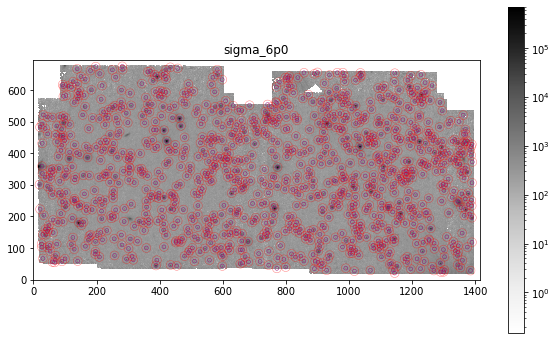

In [37]:
sigma_level = 6.

# 4 sigma seems ideal to me
# fwhm = 3. is roughly the average of many stars tested with imexam (using 1d gaussian fit)
# vicky uses radial fwhm, which varies between 4 - 6 ish; mean is ~4.9, so i'll try 5
# i like the roundness limits at +/- 0.5 personally

#daofind = DAOStarFinder(threshold = sigma_level * std, fwhm = 5.)
daofind = DAOStarFinder(threshold = sigma_level * std, fwhm = 5., roundlo = -0.5, roundhi = 0.5)
sources = daofind(data - median)   # think: do i need to subtract bkg here? or later?

pos = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(pos, r=6.)
annuli = CircularAnnulus(pos, r_in=6., r_out=14.)
all_apers = [apertures, annuli]
norm = LogNorm()
plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
apertures.plot(color='blue', lw=.5, alpha=.5)
annuli.plot(color='red', lw=.5, alpha=.5)
plt.gcf().set_size_inches(10, 6)

plotname = str(int(sigma_level)) + 'p' + str(int(10 * (sigma_level - int(sigma_level))))
plt.title('sigma_' + plotname)
#plt.savefig('images/sigma_' + plotname, dpi=500)

print(len(sources))

Performing some basic aperture photometry, summing the pixel brightness values (fluxes?) inside each aperture and annulus:

(Note: 'nan' values for apertures are where the objects are too close to the edge of the image and use some pure white in their summation, and those for the annuli are where annuli overlap)

In [10]:
phot_table = aperture_photometry(data, all_apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)

 id   xcenter   ycenter  aperture_sum_0 aperture_sum_1
        pix       pix                                 
---- --------- --------- -------------- --------------
   1 1144.9179  20.43013            nan            nan
   2  1306.302  20.66702            nan            nan
   3 1375.1525 20.458632            nan            nan
   4 1291.0274  23.95022            nan            nan
   5 1299.8671 24.265222            nan            nan
   6 1324.3011 23.299267            nan            nan
   7  1337.575 24.427416            nan            nan
   8 1017.0781 26.568878      45426.009            nan
   9 1297.7763 28.546103      154991.87            nan
  10 1067.8531 28.996855      39140.999            nan
 ...       ...       ...            ...            ...
1241 282.68834 665.26201      50652.112      146751.56
1242 582.45383 665.19198      31236.048            nan
1243 138.25208 667.61265      59317.489            nan
1244 457.16455 669.08339      28047.208            nan
1245 472.1

Estimating the local background in the annuli by finding the mean brightness within:

In [11]:
bkg_mean = phot_table['aperture_sum_1'] / annuli.area
bkg_sum = bkg_mean * apertures.area
phot_table['bkg_sum'] = bkg_sum
final_sum = phot_table['aperture_sum_0'] - bkg_sum
phot_table['residual_sum_mean'] = final_sum

#for col in final_data.colnames:
#    final_data[col].info.format = '%.8g'
print(phot_table)

 id   xcenter   ycenter  ... aperture_sum_1  bkg_sum  residual_sum_mean
        pix       pix    ...                                           
---- --------- --------- ... -------------- --------- -----------------
   1 1144.9179  20.43013 ...            nan       nan               nan
   2  1306.302  20.66702 ...            nan       nan               nan
   3 1375.1525 20.458632 ...            nan       nan               nan
   4 1291.0274  23.95022 ...            nan       nan               nan
   5 1299.8671 24.265222 ...            nan       nan               nan
   6 1324.3011 23.299267 ...            nan       nan               nan
   7  1337.575 24.427416 ...            nan       nan               nan
   8 1017.0781 26.568878 ...            nan       nan               nan
   9 1297.7763 28.546103 ...            nan       nan               nan
  10 1067.8531 28.996855 ...            nan       nan               nan
 ...       ...       ... ...            ...       ...           

Alternate method: better stats yay (sigma-clipped median in the annuli):

In [12]:
annulus_masks = annuli.to_mask(method='center') # note: exact would be overkill for local bkg estimation (read ap phot tutorial for explanation)

bkg_median = []
for mask in annulus_masks:
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data > 0]   # create 1d array of pixel values in the mask
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)

bkg_median = np.array(bkg_median)
#phot = aperture_photometry(data, apertures)
phot_table['annulus_median'] = bkg_median
phot_table['aper_bkg'] = bkg_median * apertures.area
phot_table['aper_sum_bkgsub'] = phot_table['aperture_sum_0'] - phot_table['aper_bkg']

for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)

WARNING

 id   xcenter   ycenter  ... annulus_median  aper_bkg aper_sum_bkgsub
        pix       pix    ...                                         
---- --------- --------- ... -------------- --------- ---------------
   1 1144.9179  20.43013 ...      433.71738  49052.28             nan
   2  1306.302  20.66702 ...      946.31543 107025.75             nan
   3 1375.1525 20.458632 ...      767.60413 86813.981             nan
   4 1291.0274  23.95022 ...      847.65802 95867.864             nan
   5 1299.8671 24.265222 ...      916.18106 103617.64             nan
   6 1324.3011 23.299267 ...      842.08905 95238.028             nan
   7  1337.575 24.427416 ...      870.85651  98491.55             nan
   8 1017.0781 26.568878 ...      322.16389 36435.878       8990.1305
   9 1297.7763 28.546103 ...      886.12451 100218.32       54773.546
  10 1067.8531 28.996855 ...      367.43985 41556.468      -2415.4691
 ...       ...       ... ...            ...       ...             ...
1241 282.68834 665.2

: Input data contains invalid values (NaNs or infs), which were automatically clipped. [astropy.stats.sigma_clipping]


Trying to calculate the apparent magnitudes of each star:

I think the negative 'aper_sum_bkgsub's happen in crowded areas where the annulus counts another star as the background, so the bkg value is larger than the aperture sum, or where the star itself is so dim the bkg est is higher, or a mix of both. Does this mean I need a higher threshold or fwhm to rule out the dim boyos? Who knows

In [18]:
flux_zeromag = 280.9         # from Reach et al 2005, section 5.4; for 3.6 band, = 280.9 +/- 4.1
zmag = 18.8                  # given in/calculated using IRAC handbook, section 4.8
aperture_correction = 1.125  # for 6, 6-14 pix apertures in channel 1; given in IRAC handbook, table 4.7
conv = fluxconv / exptime
negative_sums = []

phot_table['apparent_mag_mean'] = float('NaN')
phot_table['apparent_mag_median'] = float('NaN')   # idk why i have to fill the new column with NaNs first but hey ho it works

for i in range(0, len(phot_table)):
    if phot_table['residual_sum_mean'][i] >= 0:
        phot_table['apparent_mag_mean'][i] = zmag - 2.5 * math.log10(aperture_correction * conv * phot_table['residual_sum_mean'][i])
    if phot_table['aper_sum_bkgsub'][i] >= 0:
        phot_table['apparent_mag_median'][i] = zmag - 2.5 * math.log10(aperture_correction * conv * phot_table['aper_sum_bkgsub'][i])
    else:
        negative_sums.append(phot_table['id'][i])

for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)
#print(negative_sums)

print(np.count_nonzero(~np.isnan(phot_table['apparent_mag_mean'])))
print(np.count_nonzero(~np.isnan(phot_table['apparent_mag_median'])))

 id   xcenter   ycenter  ... apparent_mag_mean apparent_mag_median
        pix       pix    ...                                      
---- --------- --------- ... ----------------- -------------------
   1 1144.9179  20.43013 ...               nan                 nan
   2  1306.302  20.66702 ...               nan                 nan
   3 1375.1525 20.458632 ...               nan                 nan
   4 1291.0274  23.95022 ...               nan                 nan
   5 1299.8671 24.265222 ...               nan                 nan
   6 1324.3011 23.299267 ...               nan                 nan
   7  1337.575 24.427416 ...               nan                 nan
   8 1017.0781 26.568878 ...               nan           18.336073
   9 1297.7763 28.546103 ...               nan           16.374061
  10 1067.8531 28.996855 ...               nan                 nan
 ...       ...       ... ...               ...                 ...
1241 282.68834 665.26201 ...         17.604672           17.50

In [14]:
#phot.write('outputs/phot_table_e1.txt', format='csv', overwrite=True)

(array([ 3.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,
         0.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  2.,
         3.,  2.,  0.,  1.,  3.,  2.,  2.,  2.,  2.,  1.,  0.,  2.,  3.,
         1.,  3.,  0.,  0.,  1.,  1.,  4.,  3.,  4.,  3.,  1.,  3.,  4.,
         0.,  3.,  4.,  6.,  4.,  5.,  4.,  7.,  2.,  6.,  6.,  6.,  6.,
         3.,  6.,  7.,  6.,  4., 14.,  7.,  7., 12., 12., 10.,  6., 17.,
         6., 22., 12., 16., 15., 16., 18., 13., 15., 15., 13., 15., 11.,
        23., 18., 24., 20., 16., 24., 22., 20., 16., 17., 18., 31., 17.,
        20., 17., 14., 20., 11., 14., 19., 16., 12., 12., 14.,  9.,  8.,
         6.,  5., 12.,  8.,  6.,  4.,  2.,  4.,  5.,  6.,  3.,  2.,  4.,
         3.,  4.,  4.,  4.,  2.,  0.,  2.,  2.,  2.,  2.,  5.,  1.,  1.,
         0.,  1.,  1.,  2.,  2.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,
         0.,  1.,  0.,  0.,  3.,  0.,  1.,  0.,  1.

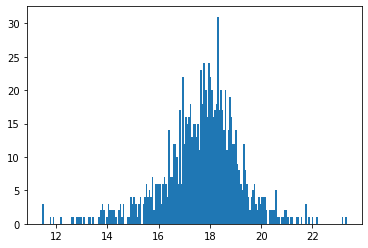

In [24]:
plt.hist(phot_table['apparent_mag_mean'], bins=200)
#plt.hist(phot_table['apparent_mag_median'], bins=200)